# Particle statistics calculations

Using Segment Anything model

In [9]:
import gzip
import logging
import pickle
from pathlib import Path

import cv2
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import Button, interact, interactive
from matplotlib import pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from tqdm.auto import tqdm

DATA_HOME = Path("<YOUR DATA FOLDER>")

sns.set(
    context="notebook",
    style="ticks",
    font="Arial",
    font_scale=1.1,
    rc={"svg.fonttype": "none", "lines.linewidth": 1.6, "figure.autolayout": True},
)

In [10]:
excel_file = pd.read_excel(DATA_HOME / "Experiments.xlsx").query('Active == "Yes"')
excel_file

,Sample name,Number of pulses,Pulse duration,Filename,Active
0,LZ-05a,150,50,LZ-05a 2024-02-21_15-06-37.jpg,Yes
1,LZ-05a,150,50,LZ-05a 2024-02-21_15-06-18.jpg,Yes
2,LZ-05a,150,50,LZ-05a 2024-02-21_15-05-56.jpg,Yes
3,LZ-05a,150,50,LZ-05a 2024-02-21_15-05-33.jpg,Yes
4,LZ-05a,150,50,LZ-05a 2024-02-21_15-05-11.jpg,Yes
...,...,...,...,...,...
138,LZ-05x,600,50,LZ-05x 2024-02-29_16-27-58.jpg,Yes
139,LZ-05x,600,50,LZ-05x 2024-02-29_16-28-20.jpg,Yes
140,LZ-05x,600,50,LZ-05x 2024-02-29_16-28-45.jpg,Yes
141,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-07.jpg,Yes


In [11]:
sample_image_files = {
    filename: DATA_HOME / filename for filename in excel_file["Filename"]
}

In [ ]:
# read image file
imgs_BGR = {id: cv2.imread(str(path)) for id, path in tqdm(sample_image_files.items())}
imgs_RGB = {id: cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for id, img in imgs_BGR.items()}
imgs_small_RGB = {
    id: cv2.resize(img, (img.shape[1] // 4, img.shape[0] // 4))
    for id, img in imgs_RGB.items()
}

Show the first few images

In [ ]:
def show_image(id):
    data = imgs_small_RGB[id]
    plt.imshow(data)
    plt.title(id)


interact(show_image, id=sample_image_files.keys())

Generate or load masks for all images

In [ ]:
mask_file = DATA_HOME / "masks.pkl.gz"

if mask_file.exists():
    with gzip.open(DATA_HOME / "masks.pkl.gz", "rb") as f:
        masks = {
            id: mask for id, mask in pickle.load(f).items() if id in imgs_small_RGB
        }
else:
    masks = {}

# Load Segment Anything model
sam = sam_model_registry["default"](checkpoint="sam_vit_h_4b8939.pth")
try:
    sam.to("cuda")
except RuntimeError:
    logging.warning("No GPU available, using CPU")
    pass
# Generate masks
mask_generator = SamAutomaticMaskGenerator(
    sam, points_per_batch=16, points_per_side=150, box_nms_thresh=0.1
)
new_masks = {
    id: mask_generator.generate(img)
    for id, img in tqdm(imgs_small_RGB.items())
    if id not in masks
}
# Save masks to pickle file
if new_masks:
    masks.update(new_masks)
    if mask_file.exists():
        # make a backup of current mask_file with a timestamp
        backup_file = mask_file.with_name(
            f'{mask_file.stem}_{pd.Timestamp.now().strftime("%Y%m%d%H%M%S")}{mask_file.suffix}'
        )
        mask_file.rename(backup_file)
    with gzip.open(mask_file, "wb") as f:
        pickle.dump(masks, f)
{id: len(img_masks) for id, img_masks in masks.items()}

In [ ]:
def show_hist(id):
    areas = np.log10(np.array([mask["area"] for mask in masks[id]]))
    plt.hist(areas, bins=100)


interact(show_hist, id=sample_image_files.keys())

In [16]:
# Remove masks that are too big
MAX_MASK_AREA = 2000
masks_filtered = {
    id: [mask for mask in img_masks if mask["area"] < MAX_MASK_AREA]
    for id, img_masks in masks.items()
}
{id: len(img_masks) for id, img_masks in masks_filtered.items()}

{'LZ-05a 2024-02-21_15-06-37.jpg': 208,
 'LZ-05a 2024-02-21_15-06-18.jpg': 104,
 'LZ-05a 2024-02-21_15-05-56.jpg': 161,
 'LZ-05a 2024-02-21_15-05-33.jpg': 262,
 'LZ-05a 2024-02-21_15-05-11.jpg': 238,
 'LZ-05a 2024-02-21_15-04-49.jpg': 257,
 'LZ-05a 2024-02-21_15-04-08.jpg': 142,
 'LZ-05a 2024-02-21_15-03-47.jpg': 155,
 'LZ-05a 2024-02-21_15-03-19.jpg': 207,
 'LZ-05a 2024-02-21_15-02-51.jpg': 165,
 'LZ-05b 2024-02-21_15-21-26.jpg': 447,
 'LZ-05b 2024-02-21_15-21-06.jpg': 460,
 'LZ-05b 2024-02-21_15-20-41.jpg': 463,
 'LZ-05b 2024-02-21_15-20-12.jpg': 408,
 'LZ-05b 2024-02-21_15-19-46.jpg': 422,
 'LZ-05b 2024-02-21_15-19-24.jpg': 508,
 'LZ-05b 2024-02-21_15-18-55.jpg': 465,
 'LZ-05b 2024-02-21_15-18-38.jpg': 392,
 'LZ-05b 2024-02-21_15-18-08.jpg': 374,
 'LZ-05b 2024-02-21_15-17-37.jpg': 451,
 'LZ-05b 2024-02-21_15-17-01.jpg': 412,
 'LZ-05h 2024-02-21_17-15-28.jpg': 399,
 'LZ-05h 2024-02-21_17-12-29.jpg': 466,
 'LZ-05h 2024-02-21_17-12-50.jpg': 474,
 'LZ-05h 2024-02-21_17-13-10.jpg': 465,


In [17]:
NDIVX = 3
NDIVY = 3

divisions = {
    id: [
        mask["point_coords"][0][0] // (img.shape[1] // NDIVX)
        + NDIVX * (mask["point_coords"][0][1] // (img.shape[0] // NDIVY))
        for mask in masks_filtered[id]
    ]
    for id, img in imgs_small_RGB.items()
}
divisions_df = (
    pd.DataFrame.from_dict(divisions, orient="index")
    .stack()
    .reset_index()
    .rename(columns={"level_0": "Filename", "level_1": "mask_id", 0: "division"})
    .astype({"division": int})
)
divisions_df = (
    divisions_df.groupby(["Filename", "division"])
    .count()
    .rename(columns={"mask_id": "# particles"})
    .reset_index()
)
divisions_df = excel_file.merge(divisions_df, on="Filename", how="right")
divisions_df

,Sample name,Number of pulses,Pulse duration,Filename,Active,division,# particles
0,LZ-05a,150,50,LZ-05a 2024-02-21_15-02-51.jpg,Yes,0,4
1,LZ-05a,150,50,LZ-05a 2024-02-21_15-02-51.jpg,Yes,1,26
2,LZ-05a,150,50,LZ-05a 2024-02-21_15-02-51.jpg,Yes,2,23
3,LZ-05a,150,50,LZ-05a 2024-02-21_15-02-51.jpg,Yes,3,11
4,LZ-05a,150,50,LZ-05a 2024-02-21_15-02-51.jpg,Yes,4,26
...,...,...,...,...,...,...,...
715,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-29.jpg,Yes,4,34
716,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-29.jpg,Yes,5,58
717,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-29.jpg,Yes,6,54
718,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-29.jpg,Yes,7,48


## Visualising the location of masks for each image

In [ ]:
mask_tensors = {
    img_id: np.stack([mask["segmentation"] for mask in masks_filtered[img_id]])
    for img_id in tqdm(masks_filtered)
}

In [ ]:
all_included = {
    img_id: np.sum(
        mask_tensors[img_id]
        * np.random.randint(1, 16, size=(mask_tensors[img_id].shape[0], 1, 1)),
        axis=0,
    )
    for img_id in tqdm(mask_tensors)
}

In [ ]:
# Color map where 0 is black and 1-16 are different colors
cmap = matplotlib.colormaps["tab20"]
# set 0 to black
cmap.colors = ((0, 0, 0, 1),) + cmap.colors[1:]


def show_fn(img_id):
    filename = img_id.replace(".jpg", ".svg")
    img = imgs_small_RGB[img_id]
    mask = all_included[img_id]
    f, (img_ax, mask_ax) = plt.subplots(1, 2, figsize=(12, 6))
    img_ax.imshow(img)
    mask_ax.imshow(mask, cmap=cmap, interpolation="none")
    mask_ax.set_title(f"{len(masks_filtered[img_id])} masks")

    b = Button(description=f"Save to {filename}")
    b.on_click(lambda x: f.savefig(filename, format="svg", transparent=True))
    display(b)


interactive(show_fn, img_id=all_included.keys())

In [35]:
# Add mask count and area to the dataframe
mask_areas = [
    pd.DataFrame(
        {
            "mask_area": [mask["area"] for mask in masks],
            "Filename": img_id,
        },
    )
    for img_id, masks in masks_filtered.items()
]
count_df = excel_file.merge(
    pd.DataFrame(
        {"# particles": [len(masks) for masks in masks_filtered.values()]},
        index=masks_filtered.keys(),
    ),
    left_on="Filename",
    right_index=True,
)
mask_df = excel_file.merge(pd.concat(mask_areas), on="Filename")
mask_df = mask_df.assign(
    **{"Diameter (µm)": np.sqrt(mask_df["mask_area"] / np.pi) * 2 / 0.906}
)

In [36]:
mask_df

,Sample name,Number of pulses,Pulse duration,Filename,Active,mask_area,Diameter (µm)
0,LZ-05a,150,50,LZ-05a 2024-02-21_15-06-37.jpg,Yes,642,31.556903
1,LZ-05a,150,50,LZ-05a 2024-02-21_15-06-37.jpg,Yes,492,27.625453
2,LZ-05a,150,50,LZ-05a 2024-02-21_15-06-37.jpg,Yes,804,35.314648
3,LZ-05a,150,50,LZ-05a 2024-02-21_15-06-37.jpg,Yes,399,24.877877
4,LZ-05a,150,50,LZ-05a 2024-02-21_15-06-37.jpg,Yes,703,33.022088
...,...,...,...,...,...,...,...
17010,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-29.jpg,Yes,46,8.447064
17011,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-29.jpg,Yes,192,17.257484
17012,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-29.jpg,Yes,249,19.652895
17013,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-29.jpg,Yes,141,14.788919


In [26]:
count_df

,Sample name,Number of pulses,Pulse duration,Filename,Active,# particles
0,LZ-05a,150,50,LZ-05a 2024-02-21_15-06-37.jpg,Yes,208
1,LZ-05a,150,50,LZ-05a 2024-02-21_15-06-18.jpg,Yes,104
2,LZ-05a,150,50,LZ-05a 2024-02-21_15-05-56.jpg,Yes,161
3,LZ-05a,150,50,LZ-05a 2024-02-21_15-05-33.jpg,Yes,262
4,LZ-05a,150,50,LZ-05a 2024-02-21_15-05-11.jpg,Yes,238
...,...,...,...,...,...,...
138,LZ-05x,600,50,LZ-05x 2024-02-29_16-27-58.jpg,Yes,412
139,LZ-05x,600,50,LZ-05x 2024-02-29_16-28-20.jpg,Yes,353
140,LZ-05x,600,50,LZ-05x 2024-02-29_16-28-45.jpg,Yes,414
141,LZ-05x,600,50,LZ-05x 2024-02-29_16-29-07.jpg,Yes,346


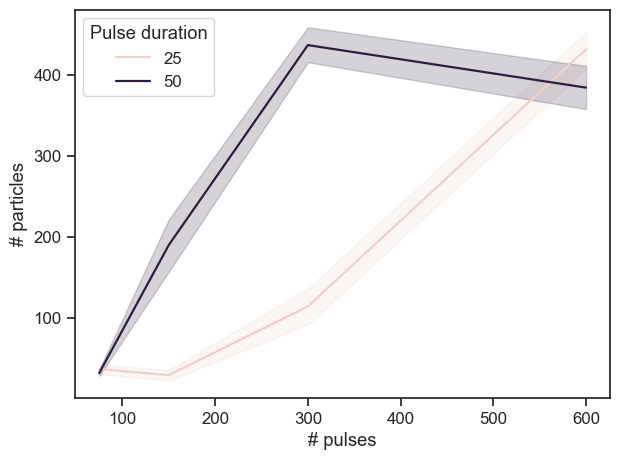

In [42]:
sns.lineplot(
    data=count_df.query("`Number of pulses` < 2400").rename(
        columns={"Number of pulses": "# pulses"}
    ),
    x="# pulses",
    y="# particles",
    hue="Pulse duration",
    # native_scale=True,
    # width=0.4,
    # log_scale=True
)
plt.savefig(
    "num_particles vs num_pulses.svg",
    transparent=True,
    bbox_inches="tight",
    pad_inches=0.1,
)

<Axes: xlabel='# pulses', ylabel='# particles'>

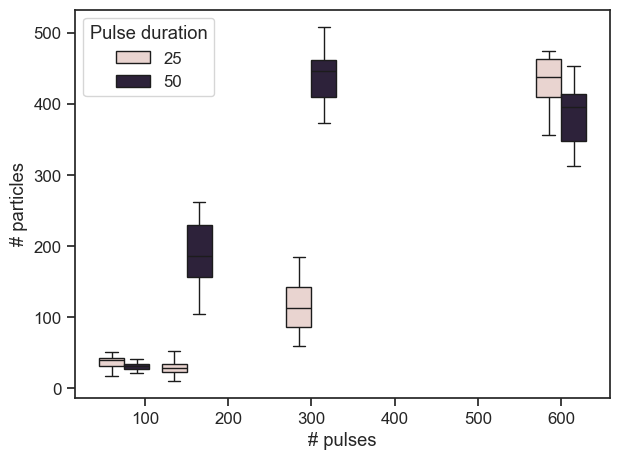

In [37]:
sns.boxplot(
    data=count_df.query("`Number of pulses` < 2400").rename(
        columns={"Number of pulses": "# pulses"}
    ),
    x="# pulses",
    y="# particles",
    hue="Pulse duration",
    native_scale=True,
    fliersize=1,
    showfliers=False,
    # width=0.4,
    # log_scale=True
)

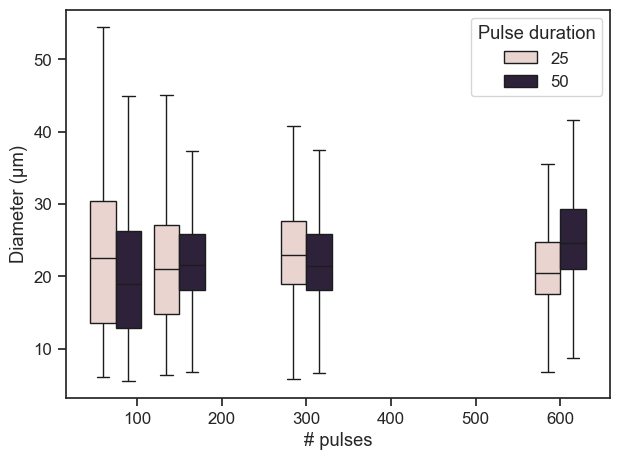

In [41]:
sns.boxplot(
    data=mask_df.query("`Number of pulses` < 2400").rename(
        columns={"Number of pulses": "# pulses"}
    ),
    x="# pulses",
    y="Diameter (µm)",
    hue="Pulse duration",
    native_scale=True,
    fliersize=1,
    showfliers=False,
    # width=0.4,
    # log_scale=True
)
plt.savefig(
    "diameter vs num_pulses.svg", transparent=True, bbox_inches="tight", pad_inches=0.1
)

<Axes: xlabel='# pulses', ylabel='Diameter (µm)'>

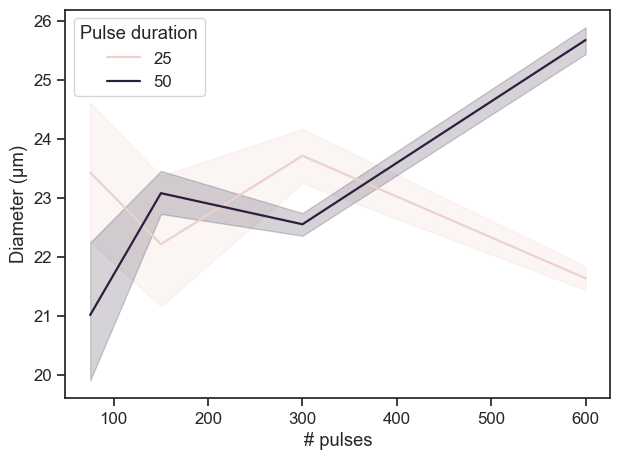

In [39]:
sns.lineplot(
    data=mask_df.query("`Number of pulses` < 2400").rename(
        columns={"Number of pulses": "# pulses"}
    ),
    x="# pulses",
    y="Diameter (µm)",
    hue="Pulse duration",
    # width=0.4,
    # log_scale=True
)

In [19]:
count_df.to_excel(DATA_HOME / "mask_counts.xlsx", index=False)
mask_df.to_excel(DATA_HOME / "mask_areas.xlsx", index=False)